In [ ]:
# Install libraries

%%capture

! pip install gdown
! pip install imbalanced-learn

In [ ]:
# Download the dataset

%%capture

! rm -rf *
# ! gdown --id 
! unzip travel_insurance.zip
! rm travel_insurance.zip

In [ ]:
# Import libraries

%%capture

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import pandas as pd
import matplotlib
import numpy as np
import itertools
import warnings
import pickle
import math
import os

# Machine learning libraries
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve , roc_auc_score

from imblearn.over_sampling import SMOTE

In [ ]:
# Show plots inside the jupyter notebook
%matplotlib inline

# Pandas settings to show more columns are rows in the jupyter notebook
pd.set_option('display.max_columns', 50000)

path = Path('travel_insurance')
target_name = "TravelInsurance"

In [ ]:
train = pd.read_csv(path/'train.csv')
submission = pd.read_csv(path/'test.csv')

In [ ]:
train, test = train_test_split(train, test_size=0.2, stratify=train.TravelInsurance, random_state=101)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


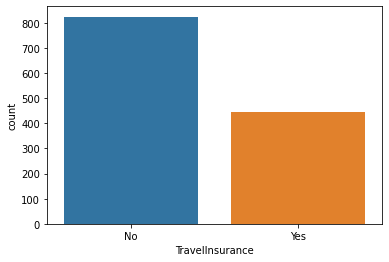

In [ ]:
sns.countplot(train.TravelInsurance);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


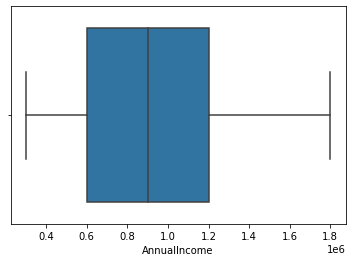

In [ ]:
sns.boxplot(train.AnnualIncome);

### people with AnnualIncome greater than 1350000 are more likely to take travel insurance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


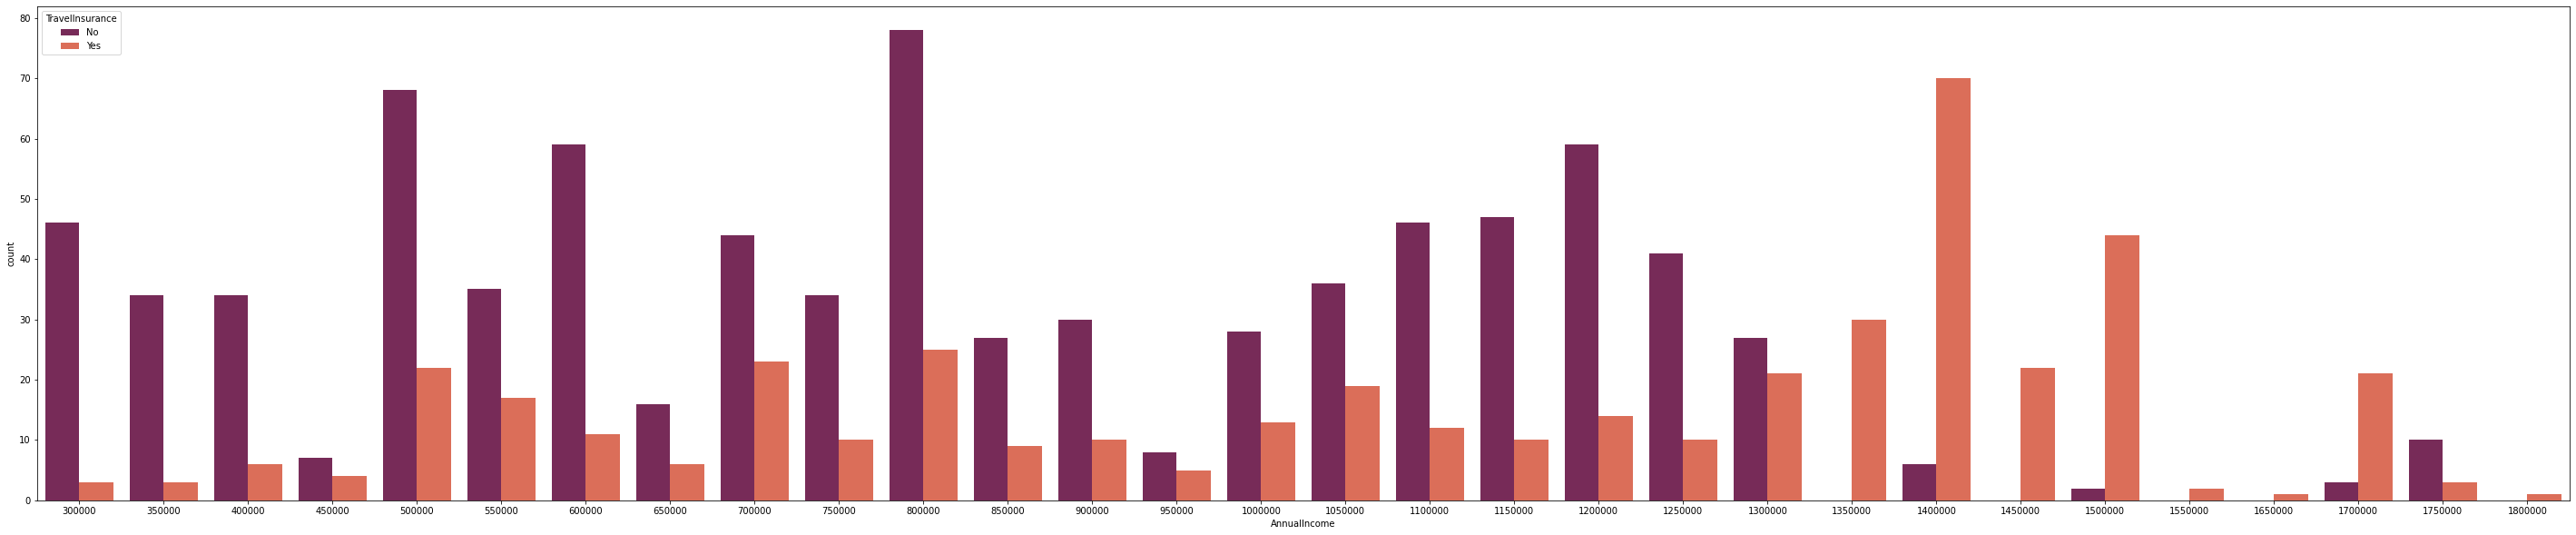

In [ ]:
plt.figure(figsize=(50,10))
sns.countplot(train.AnnualIncome, hue=train.TravelInsurance, palette='rocket');

### people older than 33 are more likely to take travel insurance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


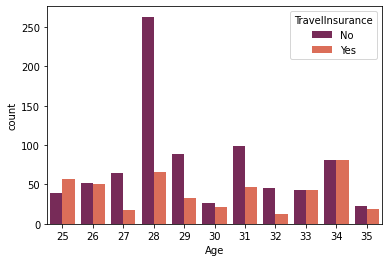

In [ ]:
sns.countplot(train.Age, hue=train.TravelInsurance, palette='rocket');

### people who travel frequently are more likely to take travel insurance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


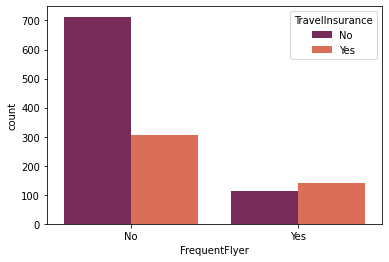

In [ ]:
sns.countplot(train.FrequentFlyer, hue=train.TravelInsurance, palette='rocket');

### people who travel abroad more are more likely to take travel insurance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


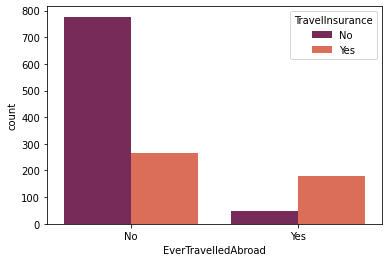

In [ ]:
sns.countplot(train.EverTravelledAbroad, hue=train.TravelInsurance, palette='rocket');

`ChronicDiseases` doesnt seem to have much inpact on the target

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


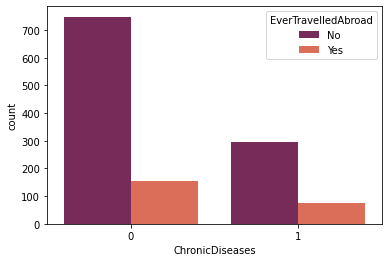

In [ ]:
sns.countplot(train.ChronicDiseases, hue=train.EverTravelledAbroad, palette='rocket');

In [ ]:
class FeatureSynthesis : 
    def __init__(self, df, annual_threshold=1350000, age_threshold=33) :
        self.df = df 
        self.annual_threshold = annual_threshold
        self.age_threshold = age_threshold

        self.categorize_annual_income()
        self.categorize_age()
    
    def categorize_annual_income(self) :
        self.df['cat_aunnual_income'] = self.df.AnnualIncome.apply(lambda val : 1 if val >= self.annual_threshold else 0)

    def categorize_age(self) : 
        self.df['cat_age'] = self.df.Age.apply(lambda val : 1 if val >= self.age_threshold else 0)

In [ ]:
train = FeatureSynthesis(train).df
test = FeatureSynthesis(test).df
submission = FeatureSynthesis(submission).df

In [ ]:
class Preproccsing : 
    def __init__(self, df, is_submission=False) :
        self.df = df

        self.drop_unnecessary_cols()
        self.encode_employment_type()
        self.encode_graduate()
        self.encode_frequent_flyer()
        self.encode_ever_traveld_aboard()
        if is_submission :
            self.encode_travel_inusrance()
    
    def drop_unnecessary_cols(self) :
        if 'Customer Id' in self.df.columns : 
            self.df.set_index('Customer Id', drop=True, inplace=True)
    
        if 'AnnualIncome' in self.df.columns : 
            self.df.drop('AnnualIncome', axis=1, inplace=True)

        if 'Age' in self.df.columns : 
            self.df.drop('Age', axis=1, inplace=True)

    def encode_employment_type(self) :
        self.df['Employment Type'].replace({
            "Government Sector" : 0 ,
            "Private Sector/Self Employed" : 1
        }, inplace= True)

    def encode_graduate(self) :
        self.df['GraduateOrNot'].replace({
            "Yes" : 1 ,
            "No" : 0
        }, inplace= True)

    def encode_frequent_flyer(self) :
        self.df['FrequentFlyer'].replace({
            "Yes" : 1,
            "No" : 0
        }, inplace= True)

    def encode_ever_traveld_aboard(self) :
        self.df['EverTravelledAbroad'].replace({
            "Yes" : 1,
            "No" : 0
        }, inplace= True)
    
    def encode_travel_inusrance(self) :
        self.df['TravelInsurance'].replace({
            "Yes" : 1 ,
            "No" : 0
        }, inplace= True)

In [ ]:
train = Preproccsing(train, True).df
test = Preproccsing(test, True).df

submission = Preproccsing(submission).df

In [ ]:
train.isna().sum()

Employment Type        0
GraduateOrNot          0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
cat_aunnual_income     0
cat_age                0
dtype: int64

# Balancing data

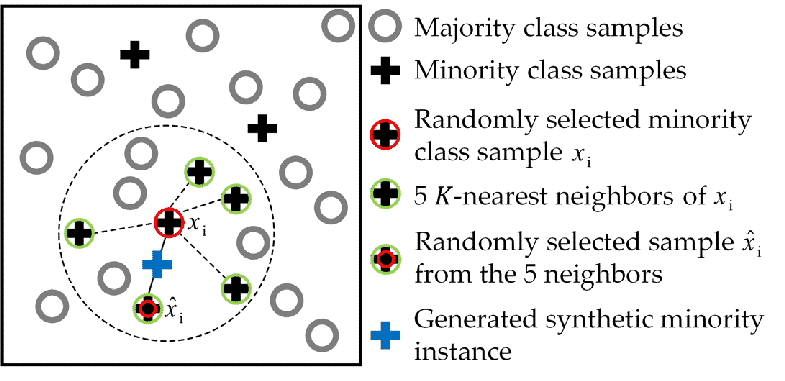

In [ ]:
train.TravelInsurance.value_counts(normalize=True)

0    0.648585
1    0.351415
Name: TravelInsurance, dtype: float64

In [ ]:
oversampler = SMOTE()
x_train, y_train = oversampler.fit_resample(train.drop('TravelInsurance', axis=1), train.TravelInsurance)

y_train.value_counts(normalize=True)

1    0.5
0    0.5
Name: TravelInsurance, dtype: float64

# modeling


In [ ]:
x_test = test.drop('TravelInsurance', axis=1)
y_test = test.TravelInsurance

In [ ]:
model = XGBClassifier(n_estimators = 45, random_state=101)

model.fit(x_train,y_train)

XGBClassifier(n_estimators=45, random_state=101)

In [ ]:
y_prob = model.predict_proba(x_test)
fpr, tpr, thresh = roc_curve(y_test, y_prob[:,1], pos_label=1)
roc_auc_score(y_test, y_prob[:,1])

0.8192614424410539

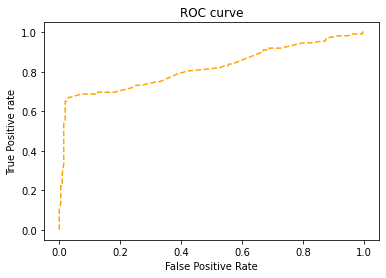

In [ ]:
plt.plot(fpr,tpr,linestyle='--',color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate');

In [ ]:
fea_imp = pd.DataFrame({
    "cols" : x_train.columns, 
    "imp" : model.feature_importances_
})

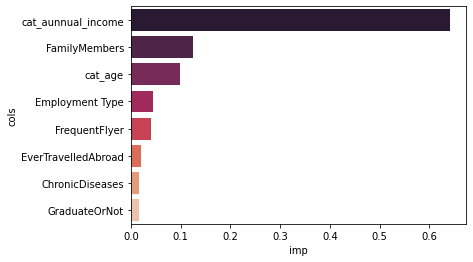

In [ ]:
fea_imp.sort_values('imp', ascending=False, inplace=True)
sns.barplot(x='imp', y='cols', data=fea_imp, palette='rocket');

# submission

In [ ]:
output = pd.DataFrame({
    'prediction' : model.predict_proba(submission)[:,1]
}, index= submission.index)

output.reset_index(inplace=True)

In [ ]:
output

,Customer Id,prediction
0,Q5OK4L2Q5XNH,0.877447
1,CBHVMVE7TRP5,0.969209
2,9UGHQ91U4F0M,0.226328
3,3UWXWMZK4ZGL,0.952571
4,5CGEMLMBOPES,0.282418
...,...,...
392,3T4IU1ZJNDIA,0.337052
393,N3ON6CQWDU4Z,0.315487
394,LWW08WASNJ2T,0.329130
395,L2RAKTUJP4HS,0.306877


In [ ]:
output.isna().sum()

Customer Id    0
prediction     0
dtype: int64

In [ ]:
output.to_csv('./output.csv', index=False)